# Workshop 4: Rising Groundwater

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px"\>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px"\>
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 1.4. Wed Sep 27, 2023.*

In this notebook we will apply the least-squares method to a non-linear model: [non-linear least-squares estimation](https://mude.citg.tudelft.nl/book/observation_theory/07_NLSQ.html). In this case our model is non-linear in the unknown parameters of interest, and as you have seen in the reading, we formulate the linearized model in terms of the difference between the initial guess and computed value of each parameter:

$$
\Delta \mathrm{x}_{[0]} = \mathrm{x}- \mathrm{x}_{[0]}
$$

We will apply best linear unbiased estimation to estimate the parameters $\Delta \mathrm{x}_{[0]}$. We will then obtain a new 'estimate' for the unknown parameters $\mathrm{x}_{[1]}=\mathrm{x}_{[0]}+\Delta \mathrm{x}_{[0]}$ and repeat the procedure. This is the Gauss-Newton iteration.

## Background

In this exercise we will consider an aquifer: a subsurface reservoir where water is stored in the pores of a soil or rock formation. If this is unfamiliar to you, think of it as an underground sponge with water in it that responds slowly to change. A well has been installed with monitoring equipment such that a time series of water level in the aquifer has been obtained, and our objective is to create a mathematical model that captures the fluctuations of the water level with time.

Water enters or exits the aquifer due to certain events, such as precipitation, evaporation or groundwater pumping. We assume that the water level in the aquifer is a linear combination of the events, allowing us to write the observation equation as:

$$ L(t) = \sum_{i=1}^{n} h_i(t) + d + \epsilon(t) $$

where $L(t)$ is the observed water level, $h_{i}(t)$ is an event that adds or removes water from the aquifer, $d$ is the base water level of the aquifer and $\epsilon(t)$ is the noise (random error) term. In this exercise we will consider the response due to a single event, $h_k(t)$. Groundwater flows through pores in the aquifer much slower than the application of $h_k(t)$ at time $t_0$. Therefore, the aquifer responds to event $k$ according to a step-response function, $s(t-t_0)$, which has the general form illustrated in the figure below. If the event has a constant value and continues indefinitely after $t_0$ the aquifer will eventually reach a steady-state value $r$ (a scaling factor of $a=1$ is used).

<div>
    <center>
        <img src="./figures/response.png", width=320 />.
    </center>
</div>

For our exercise we will consider a single event, $k$, with a constant input of water, $p$ [m], from time $t_0$ until $t_{\text{end}}$, and zero input before and after. In this case $p$ is assumed to be a deterministic (known) parameter and constant in time (imagine that it represents water inflow to the aquifer due to a rain event). The steady-state aquifer response scales with $p$, resulting in the following step-response function for the aquifer:

$$ 
h_k(t) = p \cdot \underset{s(t-t_0)}{\underbrace{r\left(1-\exp\left(-\frac{t-t_0}{a}\right)\right)}}
$$

where $a$ [days] is a scaling parameter representing the memory of the system (determines how fast the level is rising) and $r$ [m/m] is the response of the aquifier to an input $p$. Once the event stops, the response is described by:

$$ 
h_k(t) = p\cdot r\left(\exp\left(-\frac{t-t_e}{a}\right)-\exp\left(-\frac{t-t_0}{a}\right)\right), \;\; \text{for}\;\; t > t_{\text{end}} 
$$

# Functional model
---
For this example, we consider a single rainfall event. At $t_0=4$ days, it starts raining, and at $t_{\text{end}}=7$ days it stops raining (and we assume the amount of rainfall to be constant during these days, for the sake of the example...). The observation equations become:

$$
\begin{align}
    \mathbb{E}[L(t_i)] &= d && \text{for} \; t_1\leq t_i < 4\\
    \mathbb{E}[L(t_i)] &= d + p\cdot r\left(1-\exp \left(-\frac{t_i-4}{a} \right) \right) && \text{for} \; 4 \leq t_i \leq 7\\
    \mathbb{E}[L(t_{i})] &= d + p\cdot r\left(\exp \left(-\frac{t_i-7}{a} \right) - \exp \left(-\frac{t_i-4}{a}\right)\right) && \text{for} \; t_i > 7
\end{align}
$$

From these equations, it follows that there are three unknown parameters that need to be estimated: $d$, $r$ and $a$. These equations can be combined into a single equation by making use of the <a href="https://en.wikipedia.org/wiki/Heaviside_step_function"> Heaviside function</a> $H(\Delta t)$:

$$\mathbb{E}\left[L(t_i)\right] = d + H(t_i-t_{0}) \cdot p\cdot r \left(1-\exp\left(-\frac{t_i-t_0}{a}\right)\right) - H(t_i-t_{\text{end}}) \cdot p\cdot r \left(1-\exp\left(-\frac{t_i-t_{\text{end}}}{a}\right)\right)$$

with $H(\Delta t) = 1$ if $\Delta t \geq 0$ and $H(\Delta t) = 0$ otherwise. <b>Check yourself that this gives indeed the same observation equations as above.</b>

The forward model can be defined as follows, using <a href="https://numpy.org/doc/stable/reference/generated/numpy.heaviside.html"> NumPy's heaviside</a> function:           

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats.distributions import chi2
import sympy as sp

plt.rcParams.update({'font.size': 14})

In [12]:
def rain_event(t, t_0, t_end, p, d, a, r):
    '''Forward model: response due to rain event.'''
    h = d + (np.heaviside(t - t_0, 1)*p*r*(1 - np.exp(-(t - t_0)/a))\
          - np.heaviside(t - t_end, 1)*p*r*(1 - np.exp(-(t - t_end)/a)))
    return h

### <a name="forward">Forward model</a>

If we generate a vector of time steps, we can plot the (exact) response of a system with parameters using the ```rain_event``` function defined above.

The known input is: $p=0.05$ m.

Choose your own values for $d$, $a$, and $r$.

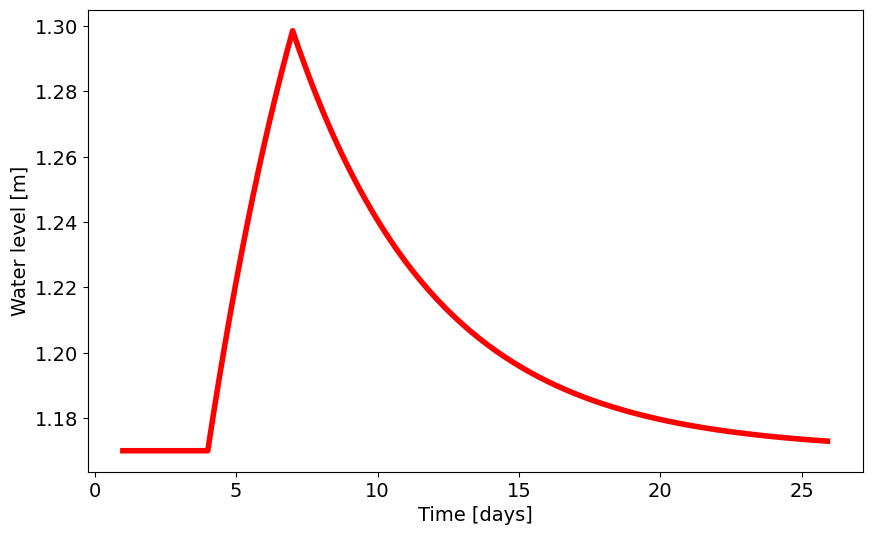

In [13]:
n_days = 25
t = np.arange(1, n_days+1, 0.1)
t_0 = 4
t_end = 7
p =  0.05

# d is the base groundwater level
d = 1.17
# a is days "the system memory"
a =  5
# r is the response of the acquifer [m/m]
r = 5.7

h_t = rain_event(t, t_0, t_end, p, d, a, r)
plt.figure(figsize=(10, 6))
plt.plot(t, h_t,'r-', linewidth=4.0)
plt.xlabel('Time [days]')
plt.ylabel('Water level [m]');

# Reading in the observations
---
We collected observations of the water level in the aquifer for 25 consecutive days and are stored ```data``` folder. Observations start at $t=1$.

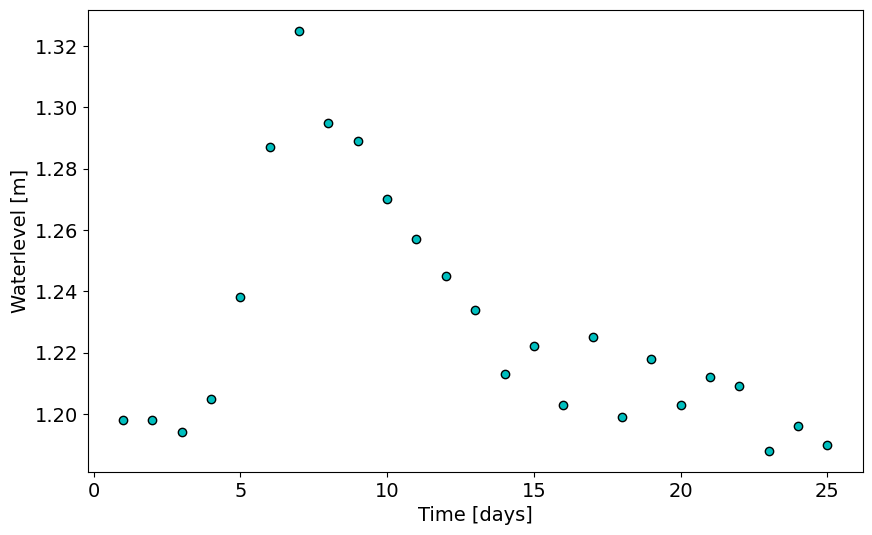

In [14]:
y = np.genfromtxt('./data/well_levels.csv' , delimiter=" ,")
t_obs = np.arange(1, n_days + 1, 1)

plt.figure(figsize=(10, 6))
plt.plot(t_obs, y,'co', mec='black')
plt.xlabel('Time [days]')
plt.ylabel('Waterlevel [m]');

# Estimating the parameters using Gauss-Newton iteration

---

Using only the data of the observations we want to find the values for $d$, $a$ and $r$. This can be done with Gauss-Newton iteration. 

The Gauss-Newton iteration works with several steps:

Start with initial guess $\mathrm{x}_{[0]}$, and start iteration with $i=0$
1. Calculate observed-minus-computed $\Delta \mathrm{y}_{[i]} = \mathrm{y} - q(\mathrm{x}_{[i]}) $
2. Determine the Jacobian $\mathrm{J}_{[i]}$
3. Estimate $\Delta \hat{\mathrm{x}}_{[i]}=\left(\mathrm{J}_{[i]}^T \Sigma_{Y}^{-1} \mathrm{J}_{[i]} \right)^{-1}\mathrm{J}_{[i]}^T \Sigma_{Y}^{-1}\Delta \mathrm{y}_{[i]}$
4. New guess $\mathrm{x}_{[i+1]}=\Delta\hat{\mathrm{x}}_{[i]}+ \mathrm{x}_{[i]}$
5. If stop criterion is met: set $\hat{\mathrm{x}}=\mathrm{x}_{[i+1]}$  and break, otherwise set $i:=i+1$ and go to step 1

Our stop criterion is:

$$
\Delta \hat{\mathrm{x}}_{[i]}^T \mathrm{N}_{[i]} \Delta \hat{\mathrm{x}}_{[i]} < \delta \;\; \text{with} \;\;\mathrm{N}_{[i]}=\mathrm{J}_{[i]}^T \Sigma_{Y}^{-1} \mathrm{J}_{[i]}
$$

## Computing the partial derivatives for the Jacobian matrix


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1:</b>   

Derive the partial derivatives that you will need for the Jacobian (on paper), and put them in the code below. 
</p>
</div>

In [15]:
def partial_derivatives(t, t_0, t_end, p, d_i, a_i, r_i):
    '''Compute partial derivates
    
    Input:
    t : array with observation times
    t_0, t_end : start and end time
    p : known input [m]
    d_i : approximate value for base level [m]
    a_i : approximate value for scaling parameter
    r_i : approximate value for response [m/m]
    
    Returns: partial derivatives w.r.t. d, a, and r
    '''
    dqdd = np.ones(len(t))
    dqda = p*r_i*((t - t_end)*np.exp((-(t - t_end)/a_i)/a_i**2)\
            * np.heaviside(t-t_end, 1)\
            - (t - t_0)*np.exp(-(t - t_0)/a_i)/a_i**2 \
            * np.heaviside(t - t_0, 1))

    dqdr = (np.heaviside(t - t_0, 1) * p * (1 - np.exp(-(t - t_0)/a_i))\
            - np.heaviside(t - t_end, 1)* p *(1 - np.exp(-(t - t_end)/a_i)))
    
    return dqdd, dqda, dqdr


## Running the Gauss-Newton iteration

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2:</b>  
    
In the code you will first need to choose the initial values ```d_i, a_i, r_i```. Hint: for the choice of ```d_i``` = $d_{[0]}$ have a look at the plot with the observations (remember it is the base level of the aquifer before the rain starts). Then play with the plot from the <a href="#forward">forward model</a> to find appropriate initial values for $a$ and $r$ by comparing the graph you get with the observations. For instance start with ```a=1``` and ```r=1```, and then start adjusting...

Next we will set the stochastic model, and initialize some other variables needed for the ```while```-loop, where the actual Gauss-Newton iteration takes place. Try to see if you can follow the steps above, and fill in the missing code, where you have to compute 
* the observed-minus-computed observations ```dy``` $=\Delta y_{[i]}$, 
* the estimate ```dxhat_i```$=\Delta\hat{\mathrm{x}}_{[i]}$, 
* ```xnrm```$=\Delta \hat{\mathrm{x}}_{[i]}^T \mathrm{N}_{[i]} \Delta \hat{\mathrm{x}}_{[i]}$.
    
Note in particular the 2 stop criteria used for the while loop. You should reach a solution within 50 iterations, otherwise you should reconsider the initial values.
    </p>
</div>

In [16]:
d_i = 1.2
a_i = 5.6
r_i = 6

sigma = 0.01
var_y = sigma**2
inv_Sigma_Y = 1/var_y * np.eye(len(y))

max_iter = 50
xnrm = 10000  # initialize stop criteria (norm of x)

# suffix "_i" indicates initial values; xhat_i stores every iteration

param_init = np.array([d_i, a_i, r_i])
xhat_i = np.zeros((3, max_iter))
xhat_i[:] = np.nan
xhat_i[:, 0] = param_init

iter_ind = 0

while xnrm >= 1e-12 and iter_ind < max_iter -1:

    y_comp = rain_event(t_obs, t_0, t_end, p, d_i, a_i, r_i)

    dy = y - y_comp
    
    J1, J2, J3 = partial_derivatives(t_obs, t_0, t_end, p, d_i, a_i, r_i)
    J   = np.column_stack((J1, J2, J3))

    dxhat_i = np.linalg.inv(J.T @ inv_Sigma_Y @ J) @ J.T @ inv_Sigma_Y @ dy
    
    xhat_i[0:3, iter_ind+1] = xhat_i[0:3, iter_ind] + dxhat_i

    d_i = xhat_i[0, iter_ind+1]
    a_i = xhat_i[1, iter_ind+1]
    r_i = xhat_i[2, iter_ind+1]

    xnrm = dxhat_i.T @ J.T @ inv_Sigma_Y @ J @ dxhat_i

    iter_ind += 1

    if iter_ind == max_iter - 1:
        print("Number of iterations too large, check initial values.")

xhat = xhat_i[:, iter_ind]
print('Final estimates:')
print(f'base level [m]:\t\t {round(xhat[0], 4)}')
print(f'scaling parameter:\t {round(xhat[1], 4)}')
print(f'response [m/m]:\t\t {round(xhat[2], 4)}')

n_par = np.shape(J)[1]
print(f'\nThe number of unknowns is {n_par}')
print(f'The number of observations is {n_days}')
print(f'The redundancy is {n_days - n_par}')

Number of iterations too large, check initial values.
Final estimates:
base level [m]:		 1.197
scaling parameter:	 5.5232
response [m/m]:		 5.8946

The number of unknowns is 3
The number of observations is 25
The redundancy is 22


**Write your answer in this Markdown cell.**

# Visualization

---

## Estimates vs. iteration number

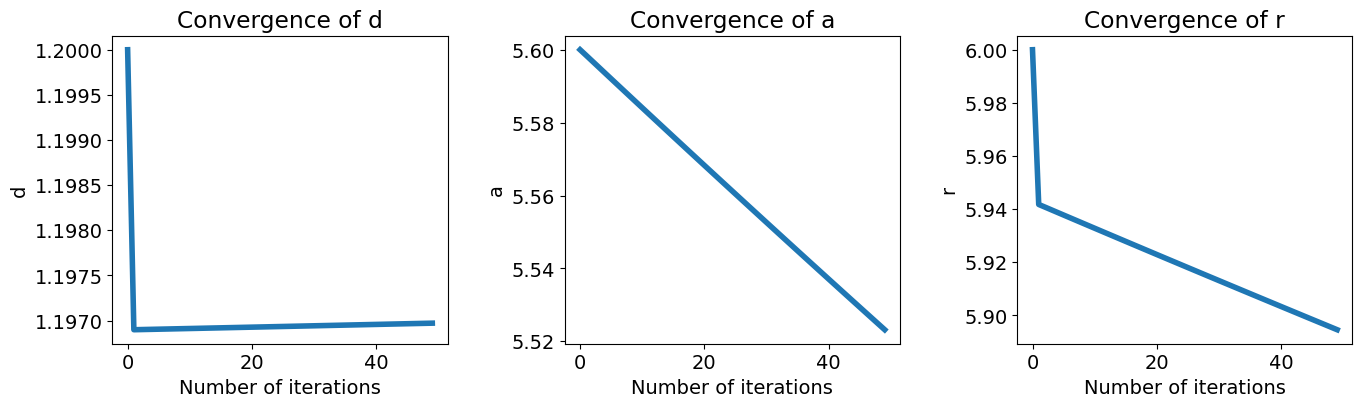

In [17]:
params = ['d', 'a', 'r']
fig, ax = plt.subplots(1,3, figsize=(16,4))
plt.subplots_adjust(wspace=0.35)
for i in range(3):
    ax[i].plot(xhat_i[i, :].T, linewidth=4)
    ax[i].set_title(f'Convergence of {params[i]}')
    ax[i].set_xlabel(f'Number of iterations')
    ax[i].set_ylabel(f'{params[i]}')

**Write your answer in this Markdown cell.**

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3:</b>  
    
Confirm the final values of each parameter by defining the variables below, then printing the values.
    </p>
</div>

In [18]:
d_final = xhat[0]
a_final = xhat[1]
r_final = xhat[2]

print(f'The final values of d, a and r are respectively {round(xhat[0], 4)}, {round(xhat[1], 4)}, {round(xhat[2], 4)} ')

The final values of d, a and r are respectively 1.197, 5.5232, 5.8946 


## Final results

Once you have defined the final values, you can use the code cell below to visualize the results.

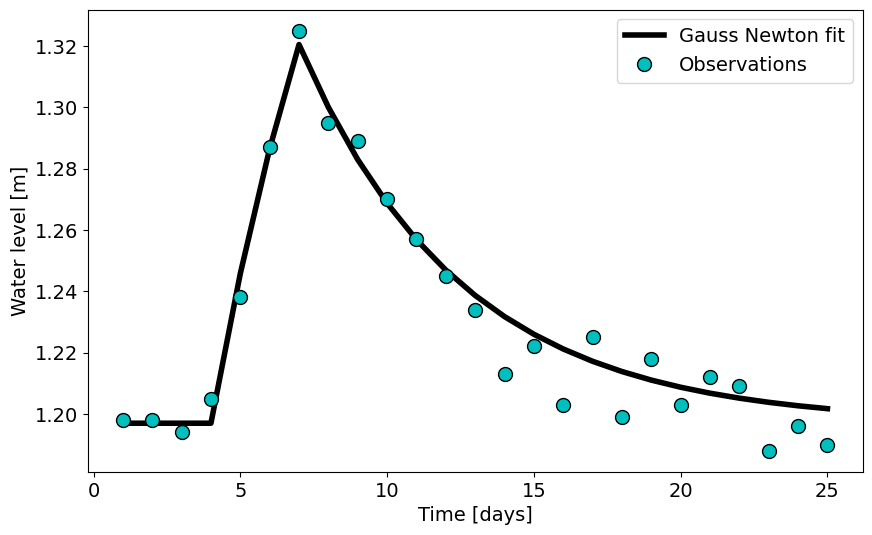

In [19]:
yhat = rain_event(t_obs, t_0=4, t_end=7, p=0.05,
                  d=d_final, a=a_final, r=r_final)

plt.figure(figsize=(10, 6))
t = np.arange(1, n_days+1, 0.1)
plt.plot(t_obs, yhat , linewidth=4,
         label='Gauss Newton fit', color='black')
plt.plot(t_obs, y, 'co', mec='black',
         markersize=10, label='Observations')
plt.legend()
plt.xlabel('Time [days]')
plt.ylabel('Water level [m]');

## Overall model test

Looking at the graph, it seems the model provides a good fit to the data. Let's test it with a probability of false alarm of 0.05.

Replace the ```?```'s in the code below to set the degrees of freedom ```q``` and use the appropriate ```if```-statement.

In [20]:
ehat = y - yhat
Tq = ehat.T @ inv_Sigma_Y @ ehat

alpha = 0.05

q = 22

k = chi2.ppf(1 - alpha, q)

if Tq<=k:
    print(f"(T = {Tq:.1f}) < (K = {k:.1f}), OMT is accepted.")
else:
    print(f"(T = {Tq:.1f}) > (K = {k:.1f}), OMT is rejected.")

(T = 17.8) < (K = 33.9), OMT is accepted.


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4:</b>  
    
Play with the value of ```alpha``` and see how it changes the critical value ```k```. Why does it become smaller/larger? What is the impact on the probability of rejecting the null hypothesis?
    </p>
</div>

The probabilty of the OMT being rejected grows bigger as alpha increases, because alpha is the rejection region and as it grows in value it causes the value of k to decrease, which in turn increases the probability of Tq > k.

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png"/>
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png"/>
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2023 <a rel="MUDE Team" href="https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=65595">MUDE Teaching Team</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fd053222-5b13-4f80-86e3-d4f09d135ba5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>